# 采集数据与模拟数据分类

基于tensorflow框架，搭建RNN网络对真实数据及模拟数据二分类

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from tensorflow.contrib import rnn

In [2]:
#设置参数
#2个类别
nclasses = 2
#每个时刻的输入特征是3维，即每时刻输入x,y,z轴
diminput = 3
#总共是1600个LSTM cell
nsteps = 1600
#隐层的节点数
dimhidden = 16
#输出的分类类别
dimoutput = nclasses#2
#采集器真实数据个数
num_sample = 32
#模拟数据个数
num_data = 500
#所有样本迭代（epoch）次数
training_epochs = 5
#一次训练batch大小
batch_size = 4

In [3]:
#加载数据并转换为array
#第一类模拟数据样本
str_file1 = 'E:/learning/testzou/MySimplePythonApplication/data/simulation1.json'#多个list
data_array = np.zeros((1,3))
file = open(str_file1,"r")
for line in file:
    data = pd.DataFrame(json.loads(str(line)))
    tem_array = data.values
    data_array = np.r_[data_array,tem_array[0:nsteps,:]]
data_array = np.delete(data_array,0,0) #data_array是其中一类样本

#第二类采集器真实数据样本
sample_array = np.zeros((1,3))
for i in range(1,33):
    filestr = "E:/learning/testzou/MySimplePythonApplication/data/" + str(i) + ".json"
    with open(filestr) as f:
        sample2 = pd.DataFrame(json.load(f))
        tem_array = sample2.values
        sample_array = np.r_[sample_array,tem_array[0:nsteps,:]]
sample_array = np.delete(sample_array,0,0)
print(data_array[0:10])

[[-3.85078448 -0.08520129 -1.4908045 ]
 [ 4.03886426 -1.81864622 -2.30038526]
 [-1.05622026 -0.84762108  0.73812294]
 [ 4.3687973  -0.95035218  0.32962863]
 [ 4.80552864 -1.56112517  0.69763546]
 [ 3.06195688 -1.94380509 -1.6739742 ]
 [-1.11414596 -1.33590631  2.46810279]
 [ 0.76489797 -0.72140242 -0.95766253]
 [-2.30039026  2.08157037  1.40258566]
 [ 0.23679495  3.07218747  2.31575871]]


In [4]:
#定义label矩阵
y1 = np.zeros((1,2))
for i in range(0,num_data):
    tem = np.array([[1,0]])
    y1 = np.r_[y1,tem]
y1=y1.reshape(-1,2)
data_label = np.delete(y1,0,0)

y2 = np.zeros((1,2))
for i in range(0,num_sample):
    tem = np.array([[0,1]])
    y2 = np.r_[y2,tem]
y2 = y2.reshape(-1,2)
sample_label = np.delete(y2,0,0)

training_label = np.r_[sample_label[0:(num_sample-2),:],data_label[0:(num_data-50),:]]
test_label = np.r_[sample_label[(num_sample-2):num_sample,:],data_label[(num_data-50):num_data,:]]
training_data = np.r_[sample_array[0:nsteps*(num_sample-2),:],data_array[0:nsteps*(num_data-50),:]]
test_data = np.r_[sample_array[nsteps*(num_sample-2):nsteps*num_sample,:],data_array[nsteps*(num_data-50):nsteps*num_data,:]]
test_data = test_data.reshape(52,nsteps,3)

In [5]:
#设置权重和偏置参数
# W["h1"]，b["b1"]为输入层到隐层的权重，大小为[3,dimhidden]
# W["h2"], b["b2"]为隐层到RNN的权重，大小为[dimhidden，nclass]
W = {"h1": tf.Variable(tf.random_normal([diminput,dimhidden])),
     "h2": tf.Variable(tf.random_normal([dimhidden, dimoutput]))}
b = {"b1": tf.Variable(tf.random_normal([dimhidden])),
     "b2": tf.Variable(tf.random_normal([dimoutput]))}

In [6]:
#创建模型
def RNN(X,W,b,nsteps):
    #RNN 的输入shape为（batch_size * LSTM的个数 * input的维度）（4 * 100 * 3）
    #把一个batch_size中，所有sample的同一时刻拉出来（100 * 4 * 3）
    X = tf.transpose(X,[1,0,2])#输入X的维度为batch_size * LSTM个数 * 神经元个数（input的维度）
    X = tf.reshape(X,[-1,diminput])#维度（400 * 3）
    H_1 = tf.matmul(X,W["h1"]) + b["b1"] 
    H_1 = tf.split(H_1, nsteps,0) 
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(dimhidden,forget_bias=1)
    LSTM_O, LSTM_S = rnn.static_rnn(lstm_cell, H_1, dtype = tf.float32)#LSTM_S为内部记忆向量，传递给下一个RNN神经元
    #LSTM_O进行softmax处理，通过概率来确定类别。
    Output = tf.matmul(LSTM_O[-1], W["h2"]) + b["b2"]
    return{"X":X,"H_1": H_1, "LSTM_O": LSTM_O, "LSTM_S": LSTM_S, "Output":Output}
print("RNN is defined")

RNN is defined


In [7]:
#设置损失，优化，学习率，准确率，参数初始化
learning_rate = 0.001
x = tf.placeholder("float", [None, nsteps, diminput])
y = tf.placeholder("float", [None, dimoutput])
myrnn = RNN(x,W,b,nsteps)
pred = myrnn['Output']
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y))
optm = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)#通过调用这个函数可以让w 参数在默认情况下标记为可训练的
accr = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred,1),tf.argmax(y,1)),tf.float32))
init = tf.global_variables_initializer()
print("forward and backprop is defined")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

forward and backprop is defined


In [8]:
#训练
display_step = 1
sess = tf.Session()
sess.run(init)
print("Start optimization")
train_acc=np.zeros(training_epochs)
test_acc=np.zeros(training_epochs)
loss=np.zeros(training_epochs)
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(len(training_data)/nsteps/batch_size)
    #循环所有batches
    for i in range(total_batch):
        batch_xs = training_data
        batch_xs = training_data[i*nsteps*batch_size:(i + 1)*nsteps*batch_size,:]  # size is [nstep * batch_size]
        batch_ys = training_label[i*batch_size:(i+1)*batch_size,:]
        batch_xs = batch_xs.reshape((batch_size, nsteps, diminput))
        #用batch数据做training
        feeds = {x:batch_xs, y:batch_ys}
        sess.run(optm,feed_dict=feeds)
        #计算平均损失
        avg_cost += sess.run(cost, feed_dict=feeds)/total_batch
        loss[epoch]=avg_cost
    #每个epoch step显示
    if epoch % display_step == 0:
        print("Epoch: %03d/%03d cost: %.9f" %(epoch, training_epochs, avg_cost))
        feeds = {x: batch_xs, y: batch_ys}
        train_acc[epoch] = sess.run(accr, feed_dict=feeds)
        print("Training accuracy: %.3f" % (train_acc[epoch]))
        #testimgs = testimgs.reshape((ntest, nsteps, diminput))
        feeds = {x:test_data, y: test_label}
        test_acc[epoch] = sess.run(accr, feed_dict=feeds)
        print("Test accuracy: %.3f" % (test_acc[epoch]))

print("Optimization Finished.")

Start optimization
Epoch: 000/005 cost: 0.669891624
Training accuracy: 1.000
Test accuracy: 0.981
Epoch: 001/005 cost: 0.118396799
Training accuracy: 1.000
Test accuracy: 1.000
Epoch: 002/005 cost: 0.063471835
Training accuracy: 1.000
Test accuracy: 1.000
Epoch: 003/005 cost: 0.044003941
Training accuracy: 1.000
Test accuracy: 1.000
Epoch: 004/005 cost: 0.033915814
Training accuracy: 1.000
Test accuracy: 1.000
Optimization Finished.


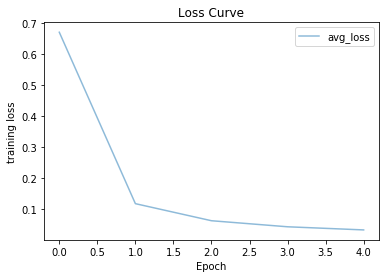

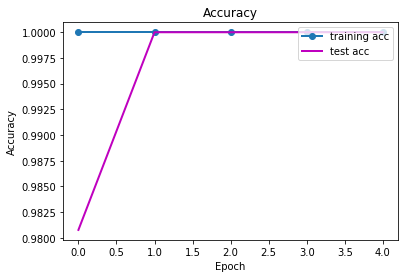

In [9]:
#损失函数曲线图
plt.figure(1)#(figsize=(20,10))
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("training loss")
plt.plot(range(training_epochs), loss, alpha=0.5, label="avg_loss")
#plt.plot(range(training_epochs),train_acc, "o-", linewidth=2, label = "training acc")
#plt.plot(range(training_epochs),test_acc,"m-", linewidth=2,label = "training acc")
plt.legend(loc="upper right")
#plt.show()

plt.figure(2)#(figsize=(20,10))
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
#plt.plot(range(training_epochs), loss, alpha=0.5, label="avg_loss")
plt.plot(range(training_epochs),train_acc, "o-", linewidth=2, label = "training acc")
plt.plot(range(training_epochs),test_acc,"m-", linewidth=2,label = "test acc")
plt.legend(loc="upper right")
#plt.show()